Convolutional Neural Network

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten, BatchNormalization , Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os , shutil ,random,glob,warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [2]:
#checks if GPU is available else CPU
if tf.config.list_physical_devices('GPU'): #checks if cuda exists or not 
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    # tf.config.experimental.set_memory_growth(device,True)
    print(tf.config.list_physical_devices('GPU'))

print(f"Using device: {device}")

[]
Using device: /cpu:0


2025-02-19 15:38:47.062520: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Data preparation

Download the dataset from this link : https://www.kaggle.com/datasets/tongpython/cat-and-dog/data

In [51]:
#organise the data into train, valid , test_dirs and inside each keep the n classes folder with data

os.mkdir('dataset/dogs-vs-cats')
original_train_path = 'dataset/cat-dog/training_set'
original_test_path = 'dataset/cat-dog/test_set'

# Create directories for the new dataset structure
os.makedirs('dataset/dogs-vs-cats/train/cats', exist_ok=True)
os.makedirs('dataset/dogs-vs-cats/train/dogs', exist_ok=True)
os.makedirs('dataset/dogs-vs-cats/valid/cats', exist_ok=True)
os.makedirs('dataset/dogs-vs-cats/valid/dogs', exist_ok=True)
os.makedirs('dataset/dogs-vs-cats/test/cats', exist_ok=True)
os.makedirs('dataset/dogs-vs-cats/test/dogs', exist_ok=True)


In [54]:

# Function to split data into train and validation sets
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    all_files = os.listdir(SOURCE)
    files = [f for f in all_files if os.path.getsize(os.path.join(SOURCE, f)) > 0]
    train_size = int(len(files) * SPLIT_SIZE)
    train_files = files[:train_size]
    valid_files = files[train_size:]
    
    for file in train_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
    
    for file in valid_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))

# Split the original training data into new training and validation sets
split_data(os.path.join(original_train_path, 'cats'), 'dataset/dogs-vs-cats/train/cats', 'dataset/dogs-vs-cats/valid/cats', 0.8)
split_data(os.path.join(original_train_path, 'dogs'), 'dataset/dogs-vs-cats/train/dogs', 'dataset/dogs-vs-cats/valid/dogs', 0.8)

# Copy the original test data to the new test directory
for category in ['cats', 'dogs']:
    for file in os.listdir(os.path.join(original_test_path, category)):
        shutil.copy(os.path.join(original_test_path, category, file), os.path.join('dataset/dogs-vs-cats/test', category, file))

In [78]:
train_path = 'dataset/dogs-vs-cats/train'
valid_path = 'dataset/dogs-vs-cats/valid'
test_path = 'dataset/dogs-vs-cats/test'

In [79]:
#image_transformation

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path,target_size=(224,224),classes=['cats','dogs'],batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path,target_size=(224,224),classes=['cats','dogs'],batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cats','dogs'],batch_size=10 , shuffle = False)

Found 6404 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [88]:
# assert train_batches.n == 1000
# assert valid_batches.n == 200
# assert test_batches.n == 100

In [81]:
imgs,labels = next(train_batches)

In [82]:
#this will plot imgs
def plotImages(images_arr):
    fig,axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..94.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data t

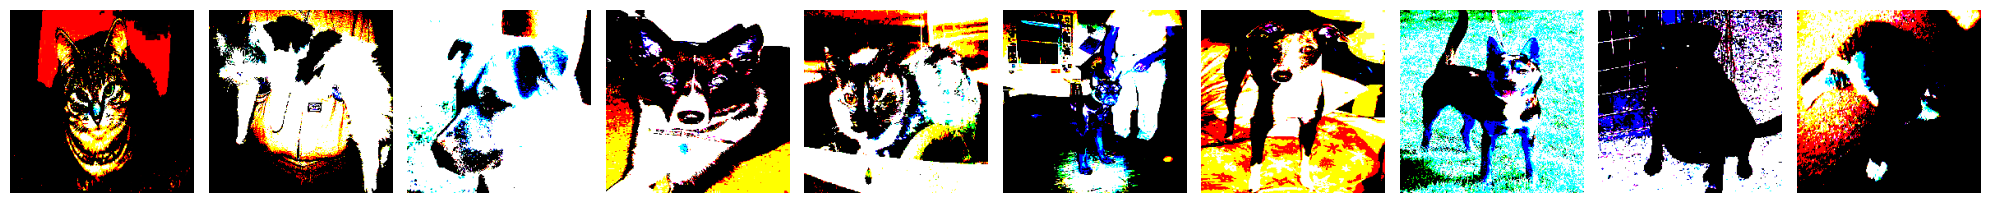

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [83]:
plotImages(imgs)
print(labels)

Build and train a CNN

In [84]:
#make the model architecture
model = Sequential(
    [
        Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2),strides=2),
        Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPool2D(pool_size=(2,2),strides=2),
        Flatten(),
        Dense(units=2,activation='softmax')
    ]
)

/home/yupcha/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [87]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10


/home/yupcha/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


641/641 - 21s - 33ms/step - accuracy: 0.6230 - loss: 5.5385 - val_accuracy: 0.6640 - val_loss: 0.9318
Epoch 2/10
641/641 - 21s - 32ms/step - accuracy: 0.8440 - loss: 0.3807 - val_accuracy: 0.6896 - val_loss: 0.8251
Epoch 3/10
641/641 - 21s - 32ms/step - accuracy: 0.9605 - loss: 0.1146 - val_accuracy: 0.6977 - val_loss: 0.9698
Epoch 4/10
641/641 - 21s - 33ms/step - accuracy: 0.9906 - loss: 0.0453 - val_accuracy: 0.7052 - val_loss: 1.0409
Epoch 5/10
641/641 - 21s - 33ms/step - accuracy: 0.9958 - loss: 0.0232 - val_accuracy: 0.6958 - val_loss: 1.1671
Epoch 6/10
641/641 - 21s - 33ms/step - accuracy: 0.9834 - loss: 0.0531 - val_accuracy: 0.6814 - val_loss: 1.1929
Epoch 7/10
641/641 - 21s - 32ms/step - accuracy: 0.9836 - loss: 0.0474 - val_accuracy: 0.6727 - val_loss: 1.3811
Epoch 8/10
641/641 - 20s - 32ms/step - accuracy: 0.9755 - loss: 0.0683 - val_accuracy: 0.6877 - val_loss: 1.3517
Epoch 9/10
641/641 - 21s - 32ms/step - accuracy: 0.9816 - loss: 0.0571 - val_accuracy: 0.6846 - val_loss: 1

It is clearly visisble that the model overfits due to difference in the training accuracy and validation accuracy , which can be easily fixed using transfer learning

Model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-98.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..81.221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..146.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to

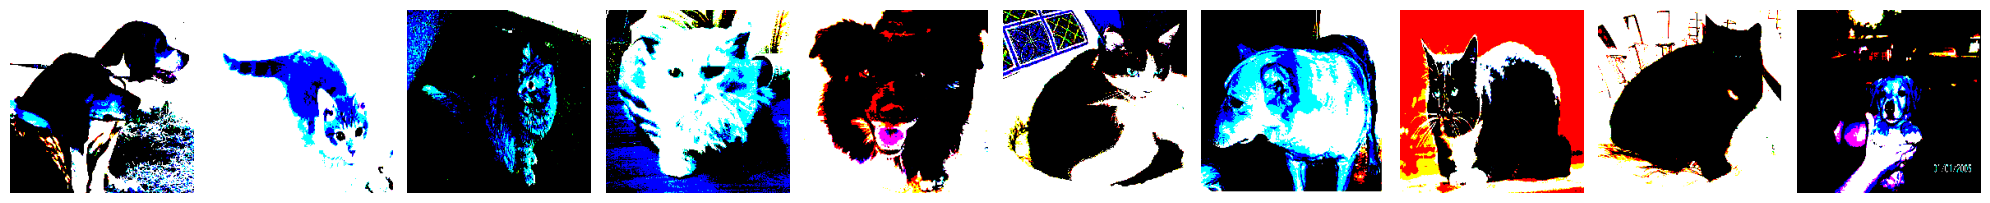

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [89]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [90]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [91]:
predictions = model.predict(x=test_batches,verbose=0)

/home/yupcha/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [92]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [93]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1)) #passing the true test labels vs predicted test labels

In [94]:
def plot_confusion_matrix(cm,classes,normalize=False,tittle='confusion_matrix',cmap=plt.cm.Blues):
    plt.imshow(cm , interpolation='nearest',cmap=cmap)
    plt.title(tittle)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("hi")
    print(cm)

    thresh= cm.max()/2
    for i,j in itertools.product(range(cm.shape[0],range(cm.shape[1]))):
        plt.text(j,i,cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j]> thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("predicted label")

In [95]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [97]:
# cm_plot_labels = ['cat','dog']
# plot_confusion_matrix(cm=cm , classes=cm_plot_labels,tittle='confusion_matrix')